In [1]:
from datetime import datetime
from utils.binaries import *
from utils.plotting import *
import uproot
import pickle

15:07:09 (   +1.4s) [INFO   ] -- import logging
15:07:09 (  +140ms) [INFO   ] -- import numpy as np
15:07:09 (    +6ms) [INFO   ] -- import uncertainties
15:07:09 (  +155ms) [INFO   ] -- import pandas as pd
15:07:09 (    +2ms) [INFO   ] -- import binaries.tools as tools
15:07:10 (  +291ms) [INFO   ] -- import matplotlib.pyplot as plt
15:07:10 (  +339ms) [INFO   ] -- import seaborn as so
15:07:10 (    +8ms) [DEBUG  ] -- font size set to 9.5
15:07:10 (    +1ms) [DEBUG  ] -- label size set to 13.0
15:07:10 (    +0ms) [DEBUG  ] -- figure size set to [6.6, 3.3]
15:07:10 (    +1ms) [DEBUG  ] -- markersize set to 2.0
15:07:10 (    +0ms) [DEBUG  ] -- usetex set to False
15:07:10 (    +2ms) [INFO   ] -- import plotting.tools as plot


In [2]:
def get_start_stop_variance(path):

    file = uproot.open(f'{path}:AugerUpTime')
    variances = np.array(file['ADCVariance'].array(), dtype=float)[:,-7:,:]
    shutter_open_fraction = np.floor(np.array(file['ShutterFraction8ADC'].array())[:,-7:])
    variances *= shutter_open_fraction[:, :, np.newaxis]

    # indices = list(range(len(variances)))
    # indices = [i for i, var in enumerate(variances) if np.mean(var) > 0]
    indices = [i for i, var in enumerate(variances) if np.all(np.logical_and(var.mean(axis=1)>0, var.mean(axis=1)<100))]

    if not len(indices): raise UserWarning(f'no entries selected for {path}!')
    start, stop = file['uptime_gpsStart'].array(), file['uptime_gpsStop'].array()
    return start[indices], stop[indices], variances[indices]

def get_calibration_constant(date, method):

    results = '/cr/data01/filip/xy-calibration/results/'

    # force preclean usage
    # date = '2023-07'

    # force postclean usage
    # date = '2023-11'

    if date < '2023-11':        # before mirror cleaning
        # print('before MC')
        heat1_run = '6020x'
        heat2_run = '6025'
        heat3_run = '6031x'
    else:                       # after mirror cleaning
        # print('after MC')
        heat1_run = '6070'
        heat2_run = '6075'
        heat3_run = '6066'
    
    co6_run = '15925x'
    co5_run = '15984x'
    co4_run = '15934x'
    co3_run = '15941x'

    heat1 = pd.read_csv(f'{results}/outCorr_{heat1_run}.txt', skiprows=5, index_col=0, delimiter=' ',
                        names=['pixel', 'calibConst', 'adcSum', 'stdCalib', 'calibConstCorr'])
    heat2 = pd.read_csv(f'{results}/outCorr_{heat2_run}.txt', skiprows=5, index_col=0, delimiter=' ',
                        names=['pixel', 'calibConst', 'adcSum', 'stdCalib', 'calibConstCorr'])
    heat3 = pd.read_csv(f'{results}/outCorr_{heat3_run}.txt', skiprows=5, index_col=0, delimiter=' ',
                        names=['pixel', 'calibConst', 'adcSum', 'stdCalib', 'calibConstCorr'])

    co6 = pd.read_csv(f'{results}/outCorr_{co6_run}.txt', skiprows=5, index_col=0, delimiter=' ',
                        names=['pixel', 'calibConst', 'adcSum', 'stdCalib', 'calibConstCorr'])
    co5 = pd.read_csv(f'{results}/outCorr_{co5_run}.txt', skiprows=5, index_col=0, delimiter=' ',
                        names=['pixel', 'calibConst', 'adcSum', 'stdCalib', 'calibConstCorr'])
    co4 = pd.read_csv(f'{results}/outCorr_{co4_run}.txt', skiprows=5, index_col=0, delimiter=' ',
                        names=['pixel', 'calibConst', 'adcSum', 'stdCalib', 'calibConstCorr'])
    co3 = pd.read_csv(f'{results}/outCorr_{co3_run}.txt', skiprows=5, index_col=0, delimiter=' ',
                        names=['pixel', 'calibConst', 'adcSum', 'stdCalib', 'calibConstCorr'])
    
    get_raw = lambda run : np.ones(440)
    get_cala = lambda run : run.stdCalib.values
    get_xy = lambda run : run.calibConstCorr.values

    match method.lower():
        case 'xy': get_calibration_constants = get_xy
        case 'cala': get_calibration_constants = get_cala
        case _: get_calibration_constants = get_raw

    return [get_calibration_constants(run) for run in [co3, co4, co5, co6, heat1, heat2, heat3]]

def to_month_dict(start, stop, var):

    month_dict = {}
    GPS_OFFSET = 315964800
    avg = [datetime.fromtimestamp(x) for x in 0.5 * (start + stop) + GPS_OFFSET]

    for t, var in zip(avg, var):
        key = t.strftime('%Y-%m')

        try:
            _ = month_dict[key]
        except KeyError:
            month_dict[key] = {'var' : np.zeros((7, 440)), 'n' : 0}

        month_dict[key]['n'] += 1
        month_dict[key]['var'] += var

    for key, value in month_dict.items():
        month_dict[key]['var'] = value['var']

    return month_dict

def combine_dict(dict1, dict2):

    combined_dict = {}
    for key in set(list(dict1.keys()) + list(dict2.keys())):
        combined_dict[key] = {}

        vals1 = dict1.get(key, {'var' : np.zeros((7, 440)), 'n' : 0})
        vals2 = dict2.get(key, {'var' : np.zeros((7, 440)), 'n' : 0})
        combined_dict[key]['var'] = vals1['var'] + vals2['var']
        combined_dict[key]['n'] = vals1['n'] + vals2['n']

    return combined_dict

def make_mask(heat_telescope_number, co_pixels):
    with open(f'../heat{heat_telescope_number}_CoOverlap.pkl', 'rb') as heat_overlap:
        heCo_overlap = pickle.load(heat_overlap)

    heat_mask = np.zeros(440)
    for i, pixel in enumerate(heCo_overlap[0]):
        tel, pix = pixel
        heat_mask[i] = co_pixels[tel-3][pix-1]

    return heat_mask


In [5]:
from datetime import datetime
from utils.Auger.FD import PixelPlot
from matplotlib.gridspec import GridSpec

files = [#'2022-10-01-12utc.root',
        #  '2023-03-01-12utc.root',
        #  '2023-04-01-12utc.root',
        #  '2023-05-01-12utc.root',
         '2023-06-01-12utc.root',
         '2023-07-01-12utc.root', 
         '2023-08-01-12utc.root', 
        #  '2023-09-01-12utc.root', 
        #  '2023-10-01-12utc.root', 
        #  '2023-11-01-12utc.root', 
         '2023-12-01-12utc.root',
         '2024-01-01-12utc.root',
         '2024-02-01-12utc.root',
        #  '2024-03-01-12utc.root',
         ]

variances = {}
for file in files:
    start, stop, var = get_start_stop_variance(file)
    this_one = to_month_dict(start, stop, var)
    variances = combine_dict(variances, this_one)


<Figure size 3960x1980 with 0 Axes>

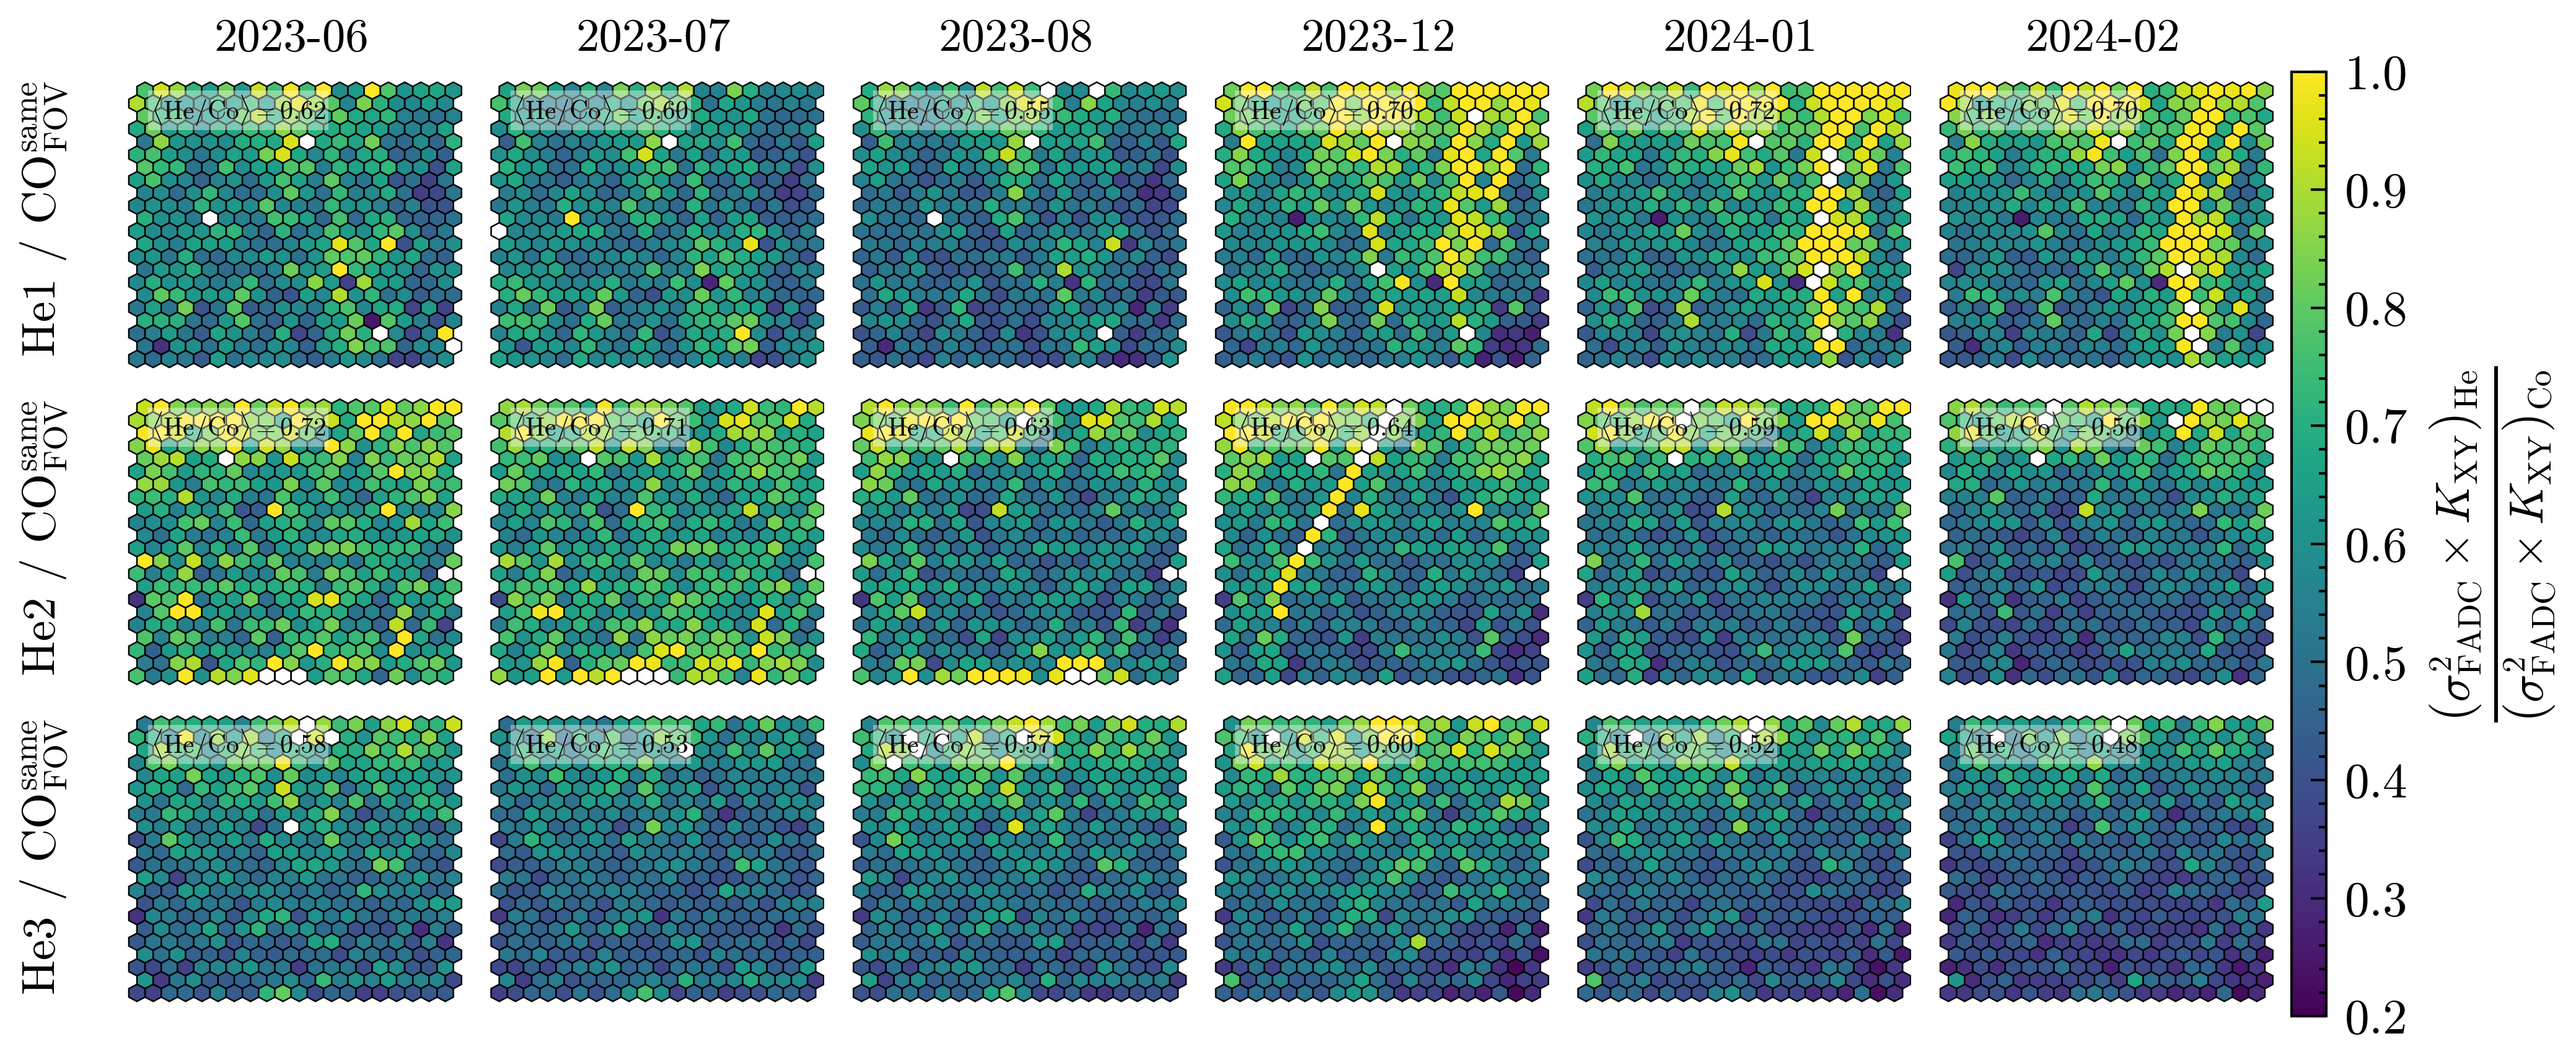

In [24]:
# fig1, laxes = plt.subplots(len(files), 1, sharey=True)
# fig1.text(.02, 0.5, 'Variance / $\mathrm{ADC}^2$', rotation=90,
#           fontdict={'ha' : 'center', 'va' : 'center', 'fontsize' : 18})
plt.subplots_adjust(hspace=0.6)

fig2 = plt.figure()
gs = GridSpec(
        3,
        len(files) + 1,
        figure=fig2,
        width_ratios=[1 for _ in files] + [0.1],
        height_ratios = [1/3, 1/3, 1/3],
    )
gs.update(left=0.05, right=0.95, wspace=0.05, hspace=0.02)
fig2.text(.02, 0.76, 'He1 / CO$^\mathrm{same}_\mathrm{FOV}$', rotation=90,
          fontdict={'ha' : 'center', 'va' : 'center', 'fontsize' : 9})
fig2.text(.02, 0.5, 'He2 / CO$^\mathrm{same}_\mathrm{FOV}$', rotation=90,
          fontdict={'ha' : 'center', 'va' : 'center', 'fontsize' : 9})
fig2.text(.02, 0.24, 'He3 / CO$^\mathrm{same}_\mathrm{FOV}$', rotation=90,
          fontdict={'ha' : 'center', 'va' : 'center', 'fontsize' : 9})

font_dict = {'fontsize' : 5, 'ha' : 'left', 'va' : 'top',}
bbox_dict = {'boxstyle' : 'square', 'fc' : 'w', 'ec' : 'none', 'alpha' : 0.4, 'pad' : 0.1}
text_kwargs = {'c' : 'k', 'weight' : 'black', **font_dict, 'bbox' : bbox_dict}

method = 'xy'
if method == '_':
    vmin, vmax = 0.5, 1.5
    name = 'raw_variance'
    symbol = ''
elif method == 'cala':
    vmin, vmax = 0.2, 1
    name = 'CalA_normalized'
    symbol = r'\times K_\mathrm{D}'
elif method == 'xy':
    vmin, vmax = 0.2, 1
    name = 'XY_normalized'
    symbol = r'\times K_\mathrm{XY}'

means_before, means_after = [], []

sorted_keys = list(variances.items())
sorted_keys.sort()
for col, (key, val) in enumerate(sorted_keys):

    mean_var_for_month = val['var'] / val['n']
    co3, co4, co5, co6 = mean_var_for_month[:4]
    he1, he2, he3 = mean_var_for_month[4:]

    # normalize with calibration constants
    calibration_constants = get_calibration_constant(key, method)
    co3_cal, co4_cal, co5_cal, co6_cal, he1_cal, he2_cal, he3_cal = calibration_constants

    co3 *= co3_cal
    co4 *= co4_cal
    co5 *= co5_cal
    co6 *= co6_cal
    he1 *= he1_cal
    he2 *= he2_cal
    he3 *= he3_cal

    he1_co_mask = make_mask(1, [co3, co4, co5, co6])
    he2_co_mask = make_mask(2, [co3, co4, co5, co6])
    he3_co_mask = make_mask(3, [co3, co4, co5, co6])

    ratios = [he1 / he1_co_mask, he2 / he2_co_mask, he3 / he3_co_mask]
    ax1, ax2, ax3 = [fig2.add_subplot(gs[i,col]) for i in range(3)]

    # remove outliers
    for i, ratio in enumerate(ratios):
        mu, sigma = ratio.mean(), ratio.std()
        ratios[i][np.abs(ratio - mu) > 3 * sigma] = np.nan

    PixelPlot(ratios[0], 'viridis', ax=ax1, lw=0.3, vmin=vmin, vmax=vmax)
    PixelPlot(ratios[1], 'viridis', ax=ax2, lw=0.3, vmin=vmin, vmax=vmax)
    PixelPlot(ratios[2], 'viridis', ax=ax3, lw=0.3, vmin=vmin, vmax=vmax)
    ax1.set_title(key, pad=4, fontsize=9)

    ax1.text(0.09, 0.93, fr'$\langle\mathrm{{He / Co}}\rangle = {np.nanmean(ratios[0]):.2f}$', transform=ax1.transAxes, **text_kwargs)
    ax2.text(0.09, 0.93, fr'$\langle\mathrm{{He / Co}}\rangle = {np.nanmean(ratios[1]):.2f}$', transform=ax2.transAxes, **text_kwargs)
    ax3.text(0.09, 0.93, fr'$\langle\mathrm{{He / Co}}\rangle = {np.nanmean(ratios[2]):.2f}$', transform=ax3.transAxes, **text_kwargs)

    if key < '2023-11':
        means_before.append(np.nanmean(ratios, axis=1))
    else:
        means_after.append(np.nanmean(ratios, axis=1))

from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
norm = Normalize(vmin, vmax)

fig2.colorbar(ScalarMappable(norm, 'viridis'), cax=fig2.add_subplot(gs[:, len(files)]),
            #   label=fr'$\langle\mathrm{{\sigma^2_\mathrm{{FADC}}}}{symbol}\rangle$ / $\mathrm{{ADC}}^2$')
            label=fr'$\frac{{\left(\sigma^2_\mathrm{{FADC}}{symbol}\right)_\mathrm{{He}}}}{{\left(\sigma^2_\mathrm{{FADC}}{symbol}\right)_\mathrm{{Co}}}}$') # / $\mathrm{{photon}}\times\mathrm{{ADC}}$')
# plot.preliminary(fig)

fig2.savefig(f'/cr/users/filip/plots/XY-heat/HeCoOverlap/HeCo_comparison_min_distance_{name}.png')

# fig2.savefig(f'/cr/users/fSilip/plots/XY-heat/NSB/{name}_shutter_corrected.png', bbox_inches='tight')
# fig1.savefig('/cr/users/filip/plots/XY-heat/NSB/time_series.png', bbox_inches='tight')

In [18]:
# raw variance
# shutter corrected

efficiency = (np.mean(means_after, axis=0) - np.nanmean(means_before, axis=0)) / np.nanmean(means_before, axis=0)
print(efficiency)

[ 0.41632672 -0.12583364  0.1251977 ]


In [16]:
# raw variance * drum_calib
# shutter corrected

efficiency = (np.mean(means_after, axis=0) - np.nanmean(means_before, axis=0)) / np.nanmean(means_before, axis=0)
print(efficiency)

[ 0.40675743 -0.12322101  0.12937925]


In [23]:
# raw variance * xy_calib
# shutter corrected

efficiency = (np.mean(means_after, axis=0) - np.nanmean(means_before, axis=0)) / np.nanmean(means_before, axis=0)
print(efficiency)

[ 0.20075011 -0.132558   -0.04677341]
